In [2]:
%matplotlib inline
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import connectome
project_root = connectome.setup_notebook(use_project_root_as_cwd=True)

sys.path.insert(0, str(project_root))

from utils.model_inspection_funcs import (
    neuron_data_from_image,
    sample_images,
)
from utils.model_inspection_utils import propagate_data_with_steps

cmap = plt.cm.binary

device = torch.device("cpu")
dtype = torch.float32

Changed working directory to /home/eudald/Desktop/doctorat/connectome
Project root: /home/eudald/Desktop/doctorat/connectome


In [3]:
visual_neuron_data = pd.read_csv(
    os.path.join(
        project_root, "new_data", "right_visual_positions_selected_neurons.csv"
    ),
    dtype={"root_id": "string"},
).drop(columns=["x", "y", "z", "PC1", "PC2"])

num_passes = 4
base_dir = os.path.join(project_root, "images", "one_to_ten", "train")
sub_dirs = ["yellow", "blue"]

sampled_images = sample_images(base_dir, sub_dirs, 1)
img = sampled_images[0]
activated_data = neuron_data_from_image(img, visual_neuron_data)

In [4]:
neuron_position_data = pd.read_table(
    os.path.join(project_root, "new_data", "neuron_annotations.tsv"),
    dtype={"root_id": "string"},
    # select root_id, pos_x, pos_y, pos_z
    usecols=["root_id", "pos_x", "pos_y", "pos_z"]
)

In [ ]:
def propagate_through_connectome(activated_data, connections, num_passes, weights=None):
    """
    Propagate activations through a connectome for a specified number of passes.

    Parameters:
    -----------
    activated_data : pd.DataFrame
        DataFrame containing initial activations with columns 'root_id' and 'activation'

    connections : pd.DataFrame
        DataFrame containing synaptic connections with columns 'pre_root_id', 'post_root_id',
        and optionally 'syn_count'

    num_passes : int
        Number of propagation passes to simulate

    weights : float, pd.DataFrame, or None
        Weights to use for connections. If None, all weights are set to 1.
        If float, all connections will have that weight.
        If DataFrame, should have the same structure as connections with a 'weight' column.

    Returns:
    --------
    propagation : pd.DataFrame
        DataFrame containing neuron IDs and their activations at each step
        Columns: 'root_id', 'input', 'activation_1', 'activation_2', ..., 'activation_n'
    """
    import pandas as pd
    import numpy as np

    # Make a copy of connections to avoid modifying the original
    connections_copy = connections.copy()

    # Get all unique neuron IDs from both sides of the connections
    all_neurons = pd.concat(
        [
            connections_copy["pre_root_id"].rename("root_id"),
            connections_copy["post_root_id"].rename("root_id"),
        ]
    ).drop_duplicates()

    # Create propagation dataframe with all neurons
    propagation = pd.DataFrame(all_neurons)
    propagation["input"] = 0

    # Set initial activations for visual neurons
    initial_activations = activated_data[["root_id", "activation"]].fillna(0)
    propagation = propagation.merge(
        initial_activations, on="root_id", how="left"
    ).fillna(0)

    # Replace the 'input' column with 'activation' values where available
    propagation["input"] = propagation["activation"].fillna(propagation["input"])
    propagation = propagation.drop(columns=["activation"])

    # Initialize activation with the same data
    activation = propagation.rename(columns={"input": "activation"})

    # Set weights for connections
    if weights is None:
        connections_copy["weight"] = 1
    elif isinstance(weights, (int, float)):
        connections_copy["weight"] = float(weights)
    elif isinstance(weights, pd.DataFrame) and "weight" in weights.columns:
        connections_copy = connections_copy.merge(
            weights[["pre_root_id", "post_root_id", "weight"]],
            on=["pre_root_id", "post_root_id"],
            how="left",
        )

    # Propagation loop
    for i in range(num_passes):
        activation = propagate_data_with_steps(activation.copy(), connections_copy, i)
        # If the propagate_data_with_steps function outputs a column named 'activation'
        if "activation" in activation.columns:
            activation = activation.rename(columns={"activation": f"activation_{i+1}"})
        propagation = propagation.merge(
            activation[
                ["root_id"]
                + [col for col in activation.columns if col.startswith("activation_")]
            ],
            on="root_id",
            how="left",
        ).fillna(0)

    return propagation

# Nuerons activated after 4 passes depending on connection matrix

## Real connectome

In [8]:
temp = pd.read_csv(
    os.path.join(project_root, "new_data", "connections.csv"),
    dtype={
        "pre_root_id": "string",
        "post_root_id": "string",
        "syn_count": np.int32,
    },
    index_col=0,
)

grouped = temp.groupby(["pre_root_id", "post_root_id"]).sum("syn_count").reset_index()

connections = grouped.sort_values(["pre_root_id", "post_root_id"])
# Get all unique neuron IDs from both sides of the connections
all_neurons = pd.concat(
    [
        connections["pre_root_id"].rename("root_id"),
        connections["post_root_id"].rename("root_id"),
    ]
).drop_duplicates()

# Create propagation dataframe with all neurons
propagation = pd.DataFrame(all_neurons)
propagation["input"] = 0

# Set initial activations for visual neurons
initial_activations = activated_data[["root_id", "activation"]].fillna(0)
propagation = propagation.merge(initial_activations, on="root_id", how="left").fillna(0)

# Replace the 'input' column with 'activation' values where available
propagation["input"] = propagation["activation"].fillna(propagation["input"])
propagation = propagation.drop(columns=["activation"])

# Initialize activation with the same data
activation = propagation.rename(columns={"input": "activation"})
connections["weight"] = 1

# Propagation loop
for i in range(num_passes):
    activation = propagate_data_with_steps(activation.copy(), connections, i)
    propagation = propagation.merge(
        activation[["root_id", f"activation_{int(i + 1)}"]],
        on="root_id",
        how="left",
    ).fillna(0)

In [5]:
temp = pd.read_csv(
    os.path.join(project_root, "new_data", "connections.csv"),
    dtype={
        "pre_root_id": "string",
        "post_root_id": "string",
        "syn_count": np.int32,
    },
    index_col=0,
)

grouped = temp.groupby(["pre_root_id", "post_root_id"]).sum("syn_count").reset_index()

connections = grouped.sort_values(["pre_root_id", "post_root_id"])

propagation = (
    activated_data[["root_id", "activation"]]
    .fillna(0)
    .rename(columns={"activation": "input"})
)
activation = activated_data[["root_id", "activation"]]
connections["weight"] = 1

for i in range(num_passes):
    activation = propagate_data_with_steps(activation.copy(), connections, i)
    propagation = propagation.merge(activation, on="root_id", how="left").fillna(0)

# find percentage of non-zero values in activation_4
propagation["activation_4"].astype(bool).sum() / len(propagation)

0.5469613259668509

In [6]:
propagation

,root_id,input,activation_1,activation_2,activation_3,activation_4
0,720575940615280638,0.0,0.0,0.000000,7.527123,4836.728471
1,720575940629819095,0.0,0.0,0.000000,0.000000,1424.806044
2,720575940614814383,0.0,0.0,0.000000,0.000000,5939.375105
3,720575940633358796,0.0,0.0,0.000000,0.000000,2849.612088
4,720575940619921172,0.0,0.0,0.000000,0.000000,132.779869
...,...,...,...,...,...,...
3072,720575940608239026,0.0,0.0,0.000000,73.214791,3872.395198
3073,720575940625986087,0.0,0.0,0.000000,23.431242,10208.635249
3074,720575940625494164,0.0,0.0,2.297228,12.168319,9237.424922
3075,720575940619775355,0.0,0.0,0.000000,2987.698114,43663.435093


/tmp/ipykernel_136941/4177365654.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])


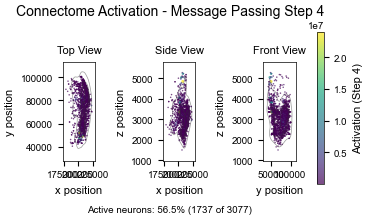

In [ ]:
from notebooks.visualization.activation_plots import create_nature_style_projection


fig = create_nature_style_projection(propagation, neuron_position_data, step=4)
plt.show()

## Completely random connections

In [10]:
# reshuffle column post_rood_id of the dataframe connections
shuffled_connections = connections.copy()
shuffled_connections["post_root_id"] = np.random.permutation(
    connections["post_root_id"]
)
propagation2 = (
    activated_data[["root_id", "activation"]]
    .fillna(0)
    .rename(columns={"activation": "input"})
)
for i in range(num_passes):
    activation = propagate_data_with_steps(activation.copy(), shuffled_connections, i)
    propagation2 = propagation2.merge(activation, on="root_id", how="left").fillna(0)

# find percentage of non-zero values in activation_4
propagation2["activation_4"].astype(bool).sum() / len(propagation2)

0.7591810204744881

/tmp/ipykernel_136941/3499530263.py:382: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # [left, bottom, right, top]


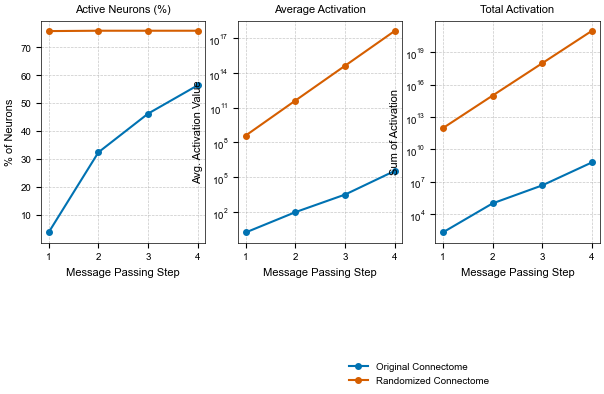

In [ ]:
from notebooks.visualization.activation_plots import create_activation_comparison_plot


fig = create_activation_comparison_plot(
    [propagation, propagation2],
    ["Original Connectome", "Randomized Connectome"],
)
plt.show()

## Random connections with reduced synaptic count

In [16]:
# reshuffle column post_rood_id of the dataframe connections
random_equalized_connections = pd.read_csv(os.path.join(project_root, "new_data", "connections_random.csv"))
propagation3 = (
    activated_data[["root_id", "activation"]]
    .fillna(0)
    .rename(columns={"activation": "input"})
)
for i in range(num_passes):
    activation = propagate_data_with_steps(activation.copy(), shuffled_connections, i)
    propagation3 = propagation3.merge(activation, on="root_id", how="left").fillna(0)

# find percentage of non-zero values in activation_4
propagation3["activation_4"].astype(bool).sum() / len(propagation3)

0.5697107572310692

In [1]:
propagation3

NameError: name 'propagation3' is not defined

## Random connections within distance bins

In [15]:
# reshuffle column post_rood_id of the dataframe connections
shuffled_connections = pd.read_csv(
    os.path.join(project_root, "new_data", "connections_random3.csv"),
    dtype={
        "pre_root_id": "string",
        "post_root_id": "string",
        "syn_count": np.int32,
        },
)
shuffled_connections["weight"] = 1
propagation4 = (
    activated_data[["root_id", "activation"]]
    .fillna(0)
    .rename(columns={"activation": "input"})
)
for i in range(num_passes):
    activation = propagate_data_with_steps(activation.copy(), shuffled_connections, i)
    propagation4 = propagation4.merge(activation, on="root_id", how="left").fillna(0)

# find percentage of non-zero values in activation_4
propagation4["activation_4"].astype(bool).sum() / len(propagation4)

0.5697107572310692

/tmp/ipykernel_136941/3499530263.py:382: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # [left, bottom, right, top]


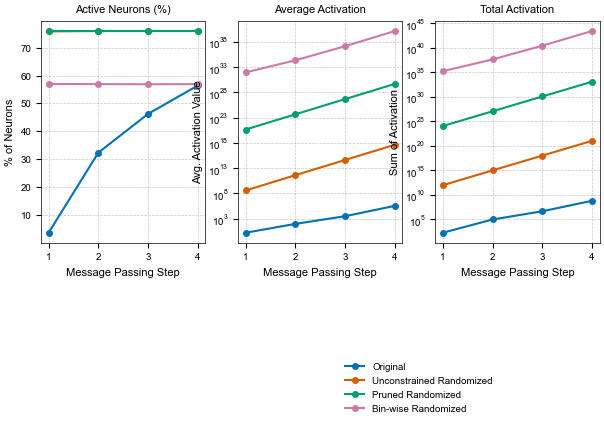

In [46]:
fig = create_activation_comparison_plot(
    [propagation, propagation2, propagation3, propagation4],
    ["Original", "Unconstrained Randomized", "Pruned Randomized", "Bin-wise Randomized"],
)
plt.show()

/tmp/ipykernel_279176/4171617863.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


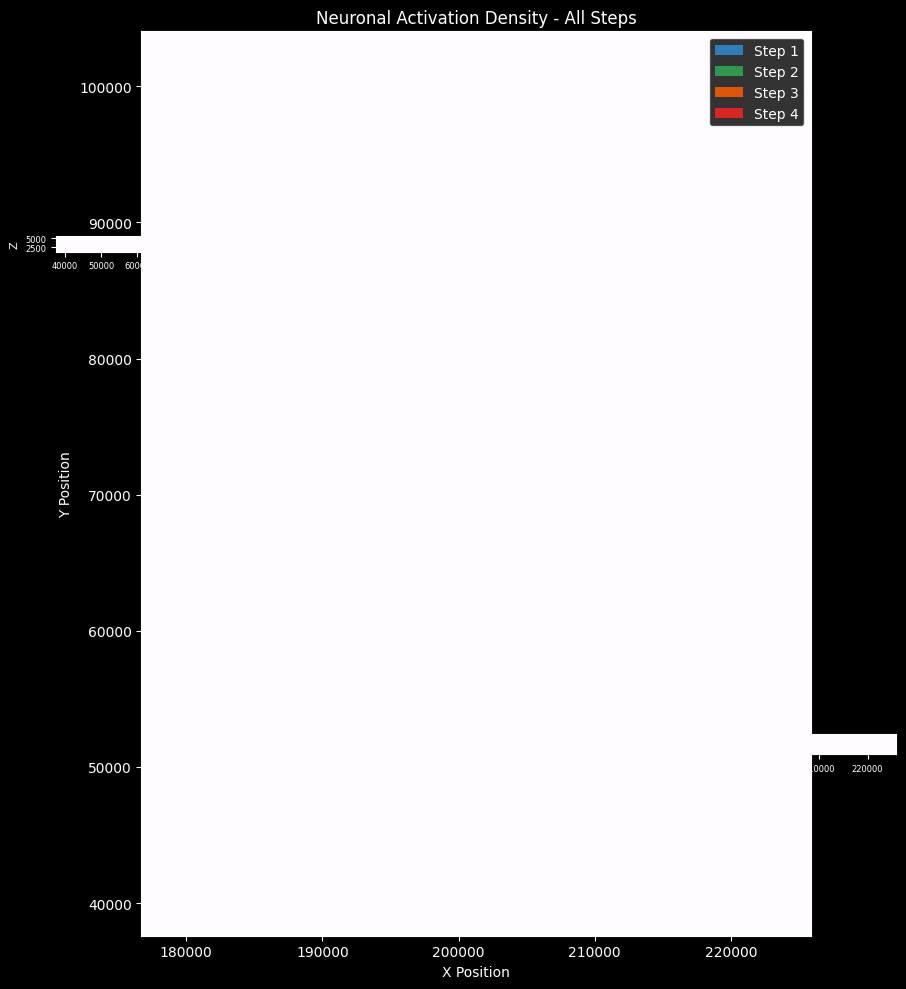

In [ ]:
from notebooks.visualization.activation_plots import create_activation_density_plot


fig1 = create_activation_density_plot(
    propagation, neuron_position_data, activation_step=None
)
plt.show()

/tmp/ipykernel_279176/4171617863.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


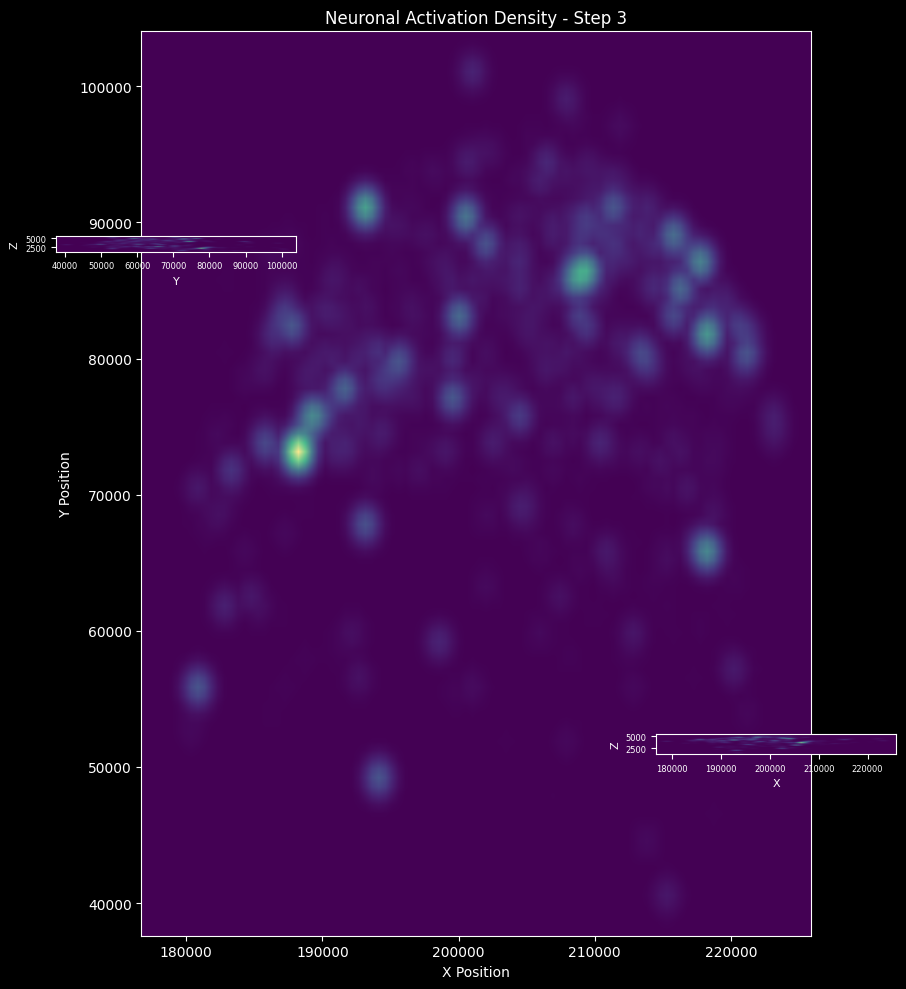

In [12]:
fig2 = create_activation_density_plot(
    propagation2, neuron_position_data, activation_step=3
)
plt.show()

In [58]:
def compare_configurations(
    propagations_dict, neuron_position_data, resolution=100, sigma=1.5, figsize=(18, 12)
):
    """
    Compare activation densities across different configurations.

    Parameters:
    -----------
    propagations_dict : dict
        Dictionary mapping configuration names to their propagation dataframes
    neuron_position_data : pandas.DataFrame
        DataFrame with neuron positions
    resolution : int
        Resolution for the 3D grid
    sigma : float
        Smoothing parameter
    figsize : tuple
        Figure size (width, height)

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure with comparison plots
    """
    fig, axes = plt.subplots(
        len(propagations_dict),
        5,
        figsize=figsize,
        facecolor="black",
        gridspec_kw={"width_ratios": [1, 1, 1, 1, 0.2]},
    )

    # Process each configuration
    for i, (config_name, prop_df) in enumerate(propagations_dict.items()):
        # Calculate percentage of active neurons for each step
        total_neurons = len(neuron_position_data)
        active_percentages = []

        for step in range(1, 5):
            act_col = f"activation_{step}"
            active_neurons = prop_df[prop_df[act_col] > 0]["root_id"].nunique()
            active_percentages.append(100 * active_neurons / total_neurons)

        # Create a bar chart for active percentages in the last column
        ax_bar = axes[i, 4]
        ax_bar.barh(
            range(4), active_percentages, color=["blue", "green", "orange", "red"]
        )
        ax_bar.set_yticks(range(4))
        ax_bar.set_yticklabels([f"Step {j+1}" for j in range(4)])
        ax_bar.set_xlabel("% Active", color="white")
        ax_bar.tick_params(colors="white")
        ax_bar.set_title(f"{config_name}", color="white")
        for spine in ax_bar.spines.values():
            spine.set_color("white")

        # Create density plots for each step
        for step in range(1, 5):
            ax = axes[i, step - 1]

            # Generate density for this step and configuration
            merged_data = pd.merge(prop_df, neuron_position_data, on="root_id")
            step_data = merged_data[merged_data[f"activation_{step}"] > 0]

            # Skip if no activations
            if len(step_data) == 0:
                ax.text(
                    0.5,
                    0.5,
                    "No activations",
                    color="white",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                )
                continue

            # Get bounds
            x_min, x_max = (
                neuron_position_data["pos_x"].min(),
                neuron_position_data["pos_x"].max(),
            )
            y_min, y_max = (
                neuron_position_data["pos_y"].min(),
                neuron_position_data["pos_y"].max(),
            )

            # Create 2D histogram
            H, xedges, yedges = np.histogram2d(
                step_data["pos_x"],
                step_data["pos_y"],
                bins=resolution,
                range=[[x_min, x_max], [y_min, y_max]],
                weights=step_data[f"activation_{step}"].values,
            )

            # Smooth
            H_smooth = gaussian_filter(H, sigma=sigma)

            # Plot
            colors = ["Blues", "Greens", "Oranges", "Reds"]
            im = ax.imshow(
                H_smooth.T,
                origin="lower",
                extent=[x_min, x_max, y_min, y_max],
                interpolation="bilinear",
                cmap=colors[step - 1],
                aspect="auto",
            )

            ax.set_title(f"Step {step}", color="white")
            ax.set_xlabel("X" if i == len(propagations_dict) - 1 else "", color="white")
            ax.set_ylabel("Y" if step == 1 else "", color="white")
            ax.tick_params(colors="white")

            for spine in ax.spines.values():
                spine.set_color("white")

    # Add row labels for configurations
    for i, config_name in enumerate(propagations_dict.keys()):
        fig.text(
            0.01,
            0.5 + (i - len(propagations_dict) + 1) / (2 * len(propagations_dict)),
            config_name,
            rotation=90,
            ha="center",
            va="center",
            color="white",
            fontsize=12,
            fontweight="bold",
        )

    plt.tight_layout()
    plt.subplots_adjust(left=0.05, wspace=0.3, hspace=0.3)

    return fig


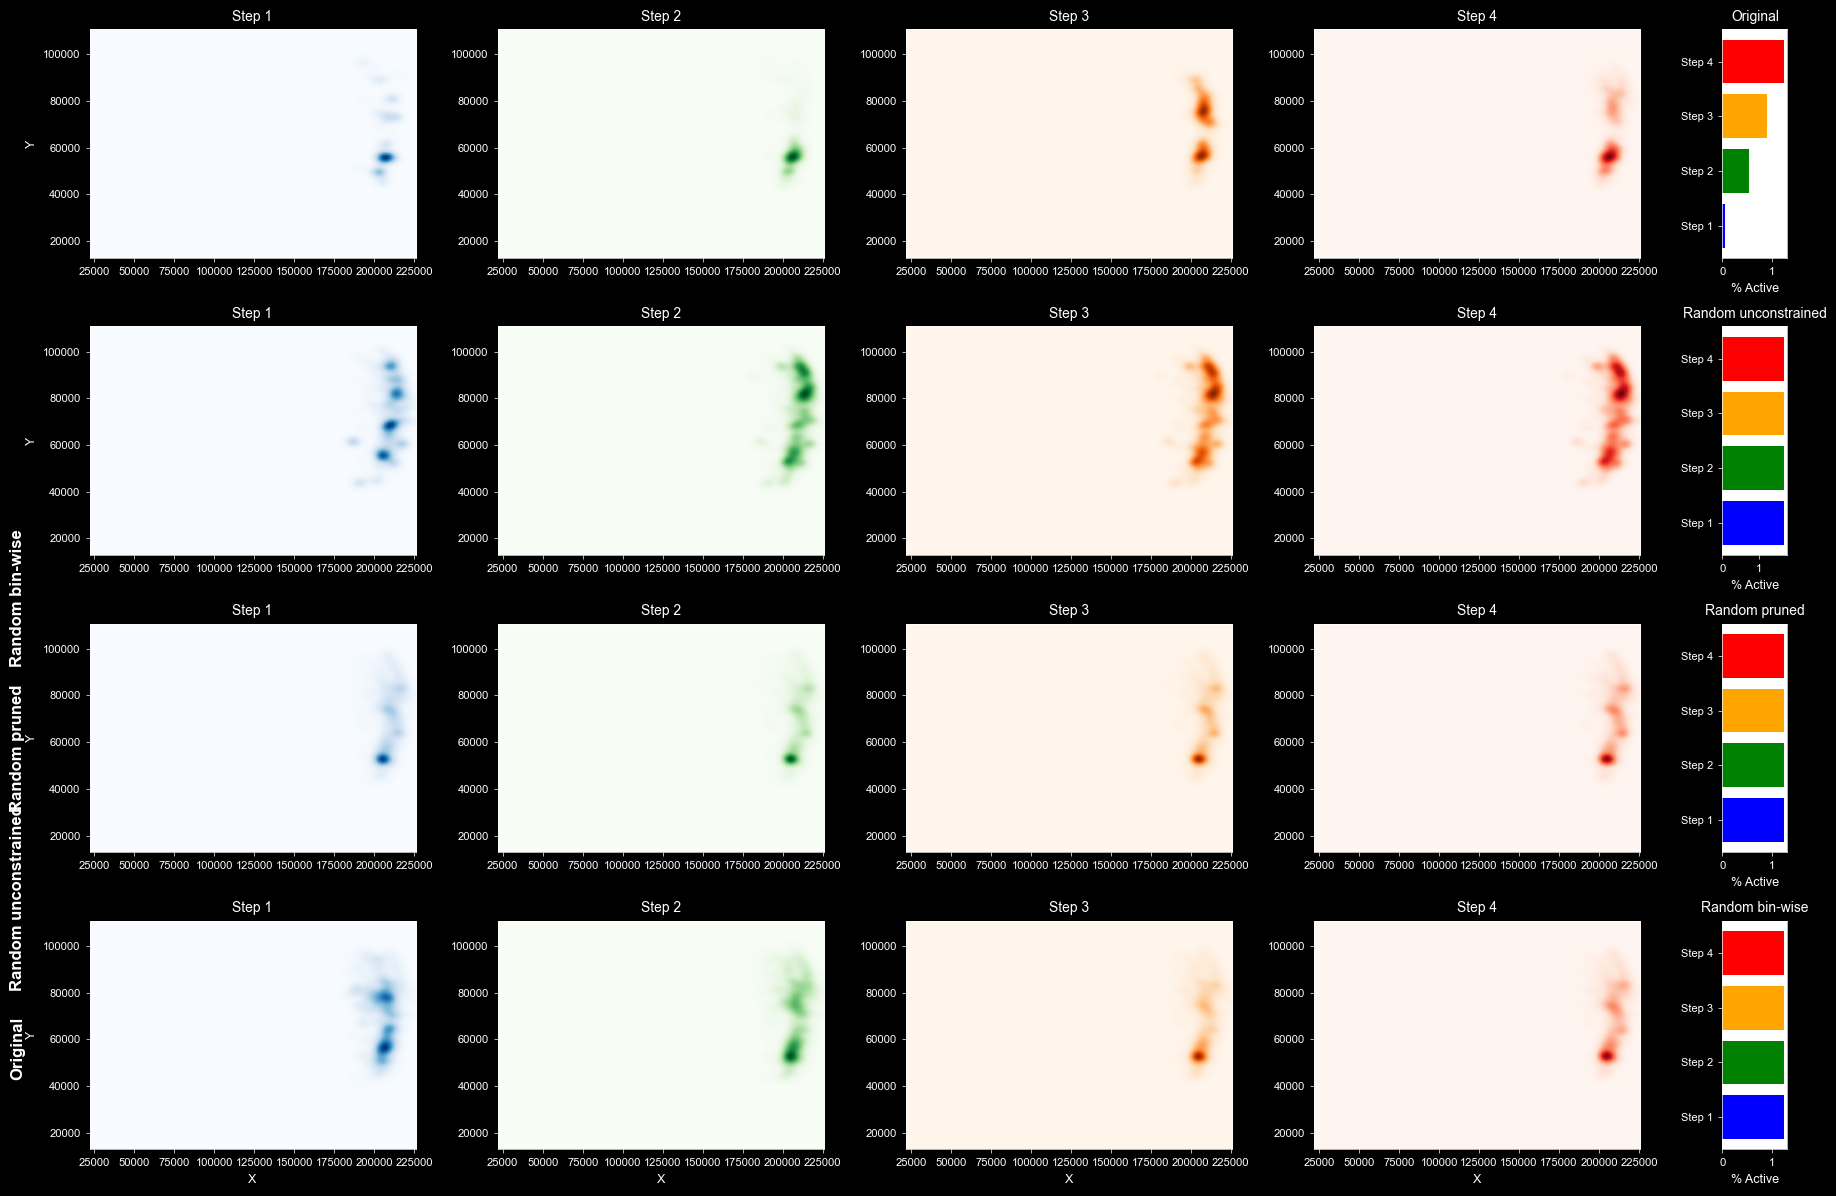

In [59]:
# Example usage with multiple configurations
configurations = {
    "Original": propagation,
    "Random unconstrained": propagation2,
    "Random pruned": propagation3,
    "Random bin-wise": propagation4,
    # Add more configurations as needed
}

fig = compare_configurations(configurations, neuron_position_data)
plt.show()

/tmp/ipykernel_279176/3632491607.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


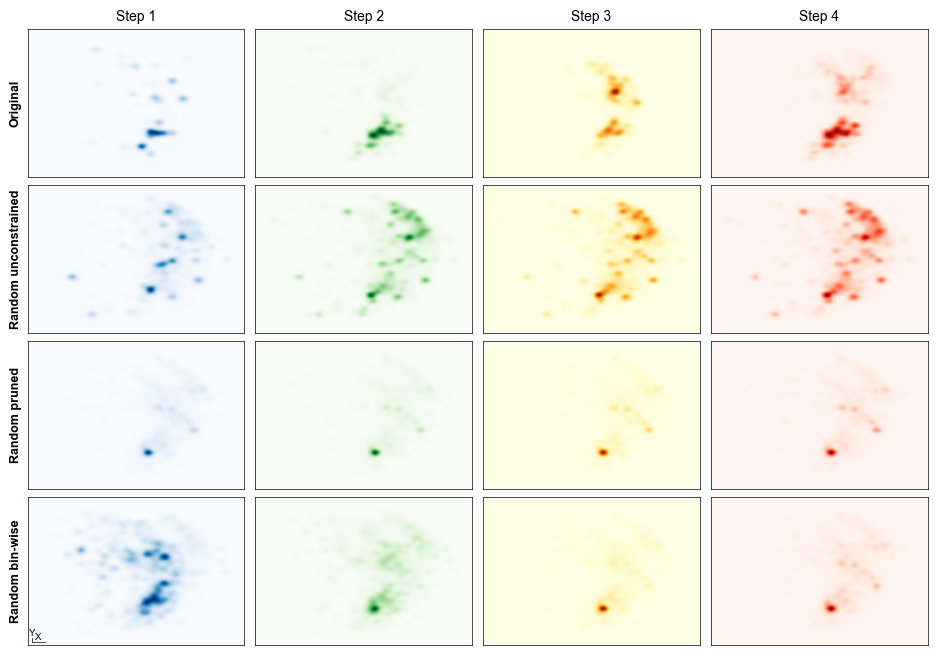

In [64]:
def compare_configurations(
    propagations_dict, neuron_position_data, resolution=100, sigma=1.5, figsize=(12, 8)
):
    """
    Compare activation densities across different configurations.

    Parameters:
    -----------
    propagations_dict : dict
        Dictionary mapping configuration names to their propagation dataframes
    neuron_position_data : pandas.DataFrame
        DataFrame with neuron positions
    resolution : int
        Resolution for the 3D grid
    sigma : float
        Smoothing parameter
    figsize : tuple
        Figure size (width, height)

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure with comparison plots
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from scipy.ndimage import gaussian_filter

    # Set figure style for Nature
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial"],
            "font.size": 8,
            "axes.linewidth": 0.5,
            "xtick.major.width": 0.5,
            "ytick.major.width": 0.5,
            "axes.labelsize": 9,
            "axes.titlesize": 10,
        }
    )

    # Get bounds of active neurons
    bounds = get_active_neuron_bounds(
        propagations_dict, neuron_position_data, padding_percent=10
    )
    x_min, x_max = bounds["x_min"], bounds["x_max"]
    y_min, y_max = bounds["y_min"], bounds["y_max"]

    # Create figure with only the activation maps (no percentage bars)
    fig = plt.figure(figsize=figsize, facecolor="white")

    # Create gridspec with additional space for y-axis labels
    gs = fig.add_gridspec(
        len(propagations_dict),
        4,
        width_ratios=[1, 1, 1, 1],
        wspace=0.05,
        hspace=0.05,
        left=0.15,
    )  # Add more space for y-axis labels

    # Colors for each step - using more distinct colors
    cmaps = ["Blues", "Greens", "YlOrBr", "Reds"]

    # Process each configuration
    for i, (config_name, prop_df) in enumerate(propagations_dict.items()):
        # Create density plots for each step
        for step in range(1, 5):
            ax = fig.add_subplot(gs[i, step - 1])
            ax.set_facecolor("none")  # Transparent background

            # Generate density for this step and configuration
            merged_data = pd.merge(prop_df, neuron_position_data, on="root_id")
            step_data = merged_data[merged_data[f"activation_{step}"] > 0]

            # Skip if no activations
            if len(step_data) == 0:
                ax.text(
                    0.5,
                    0.5,
                    "No activations",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                )
                continue

            # Create 2D histogram
            H, xedges, yedges = np.histogram2d(
                step_data["pos_x"],
                step_data["pos_y"],
                bins=resolution,
                range=[[x_min, x_max], [y_min, y_max]],
                weights=step_data[f"activation_{step}"].values,
            )

            # Smooth
            H_smooth = gaussian_filter(H, sigma=sigma)

            # Plot
            im = ax.imshow(
                H_smooth.T,
                origin="lower",
                extent=[x_min, x_max, y_min, y_max],
                interpolation="bilinear",
                cmap=cmaps[step - 1],
                aspect="auto",
            )

            # Only add step titles to the top row
            if i == 0:
                ax.set_title(f"Step {step}", fontsize=10)

            # Only add configuration labels to the leftmost column
            if step == 1:
                ax.set_ylabel(config_name, fontsize=9, fontweight="bold")

            # Remove most axis ticks and labels but keep minimal x/y reference
            ax.set_xticks([])
            ax.set_yticks([])

            # Only add x/y indicators in specific places
            if i == len(propagations_dict) - 1 and step == 1:
                # Add small x and y text indicators at bottom left of the figure
                ax.text(
                    x_min + (x_max - x_min) * 0.05,
                    y_min + (y_max - y_min) * 0.05,
                    "X",
                    fontsize=7,
                    ha="center",
                    va="center",
                )
                ax.text(
                    x_min + (x_max - x_min) * 0.02,
                    y_min + (y_max - y_min) * 0.08,
                    "Y",
                    fontsize=7,
                    ha="center",
                    va="center",
                )

                # Add a small L-shaped coordinate indicator
                ax.plot(
                    [
                        x_min + (x_max - x_min) * 0.02,
                        x_min + (x_max - x_min) * 0.02,
                        x_min + (x_max - x_min) * 0.08,
                    ],
                    [
                        y_min + (y_max - y_min) * 0.05,
                        y_min + (y_max - y_min) * 0.02,
                        y_min + (y_max - y_min) * 0.02,
                    ],
                    "k-",
                    linewidth=0.5,
                )

            # Set border properties
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color("black")
                spine.set_linewidth(0.5)

    plt.tight_layout()


    return fig


def get_active_neuron_bounds(
    propagations_dict, neuron_position_data, padding_percent=10
):
    """
    Calculate the bounds of active neurons across all configurations.

    Parameters:
    -----------
    propagations_dict : dict
        Dictionary with configuration names and propagation dataframes
    neuron_position_data : pandas.DataFrame
        DataFrame with neuron positions
    padding_percent : float
        Percentage of padding to add around the active neurons

    Returns:
    --------
    bounds : dict
        Dictionary with keys 'x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max'
    """
    import pandas as pd

    # Create lists to store all active neuron positions
    all_active_x = []
    all_active_y = []
    all_active_z = []

    # Process each configuration
    for config_name, prop_df in propagations_dict.items():
        # Merge with position data
        merged_data = pd.merge(prop_df, neuron_position_data, on="root_id")

        # Collect positions of all active neurons (in any step)
        active_mask = merged_data["activation_1"] > 0
        for step in range(2, 5):
            active_mask |= merged_data[f"activation_{step}"] > 0

        active_neurons = merged_data[active_mask]

        # Skip if no active neurons
        if len(active_neurons) == 0:
            continue

        # Add to lists
        all_active_x.extend(active_neurons["pos_x"].values)
        all_active_y.extend(active_neurons["pos_y"].values)
        all_active_z.extend(active_neurons["pos_z"].values)

    # If no active neurons found in any configuration, use full bounds
    if not all_active_x:
        return {
            "x_min": neuron_position_data["pos_x"].min(),
            "x_max": neuron_position_data["pos_x"].max(),
            "y_min": neuron_position_data["pos_y"].min(),
            "y_max": neuron_position_data["pos_y"].max(),
            "z_min": neuron_position_data["pos_z"].min(),
            "z_max": neuron_position_data["pos_z"].max(),
        }

    # Calculate bounds of active neurons
    x_min, x_max = min(all_active_x), max(all_active_x)
    y_min, y_max = min(all_active_y), max(all_active_y)
    z_min, z_max = min(all_active_z), max(all_active_z)

    # Add padding
    pad_x = (x_max - x_min) * padding_percent / 100
    pad_y = (y_max - y_min) * padding_percent / 100
    pad_z = (z_max - z_min) * padding_percent / 100

    x_min -= pad_x
    x_max += pad_x
    y_min -= pad_y
    y_max += pad_y
    z_min -= pad_z
    z_max += pad_z

    return {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "z_min": z_min,
        "z_max": z_max,
    }


def plot_activation_percentages(
    propagations_dict, neuron_position_data, figsize=(5, 6)
):
    """
    Create a separate plot for activation percentages.

    Parameters:
    -----------
    propagations_dict : dict
        Dictionary mapping configuration names to their propagation dataframes
    neuron_position_data : pandas.DataFrame
        DataFrame with neuron positions
    figsize : tuple
        Figure size (width, height)

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure with percentage bars
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Set figure style
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial"],
            "font.size": 8,
            "axes.linewidth": 0.5,
        }
    )

    # Create figure
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")

    # Bar colors for each step
    bar_colors = ["#4575b4", "#4daf4a", "#ff7f00", "#d73027"]

    # Step labels
    step_labels = [f"Step {i+1}" for i in range(4)]

    # Number of configurations and steps
    n_configs = len(propagations_dict)
    n_steps = 4

    # Calculate bar positions
    bar_width = 0.7
    config_names = list(propagations_dict.keys())

    # Process each configuration
    all_percentages = []

    for config_name, prop_df in propagations_dict.items():
        # Calculate percentage of active neurons for each step
        total_neurons = len(neuron_position_data)
        percentages = []

        for step in range(1, 5):
            act_col = f"activation_{step}"
            active_neurons = prop_df[prop_df[act_col] != 0]["root_id"].nunique()
            percentages.append(100 * active_neurons / total_neurons)

        all_percentages.append(percentages)

    # Convert to numpy array for easier manipulation
    all_percentages = np.array(all_percentages)

    # Create grouped bar chart
    x = np.arange(n_configs)
    for i in range(n_steps):
        ax.bar(
            x + (i - 1.5) * bar_width / n_steps,
            all_percentages[:, i],
            width=bar_width / n_steps,
            label=step_labels[i],
            color=bar_colors[i],
        )

    # Add labels and legend
    ax.set_xticks(x)
    ax.set_xticklabels(config_names, rotation=45, ha="right")
    ax.set_ylabel("% Active Neurons", fontsize=9)
    ax.set_title("Percentage of Active Neurons by Configuration and Step", fontsize=10)
    ax.legend(loc="upper left", frameon=True)

    # Add grid for readability
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Adjust for labels
    plt.tight_layout()

    return fig


# Example usage
"""
configurations = {
    "Original": propagation,
    "Random unconstrained": propagation2,
    "Random pruned": propagation3,
    "Random bin-wise": propagation4,
}

# Plot main activation maps
fig1 = compare_configurations(configurations, neuron_position_data)
plt.savefig('neural_activation_maps.pdf', dpi=300, bbox_inches='tight')
plt.savefig('neural_activation_maps.png', dpi=300, bbox_inches='tight')

# Plot activation percentages separately
fig2 = plot_activation_percentages(configurations, neuron_position_data)
plt.savefig('activation_percentages.pdf', dpi=300, bbox_inches='tight')
plt.savefig('activation_percentages.png', dpi=300, bbox_inches='tight')

plt.show()
"""


# Example usage

configurations = {
    "Original": propagation,
    "Random unconstrained": propagation2,
    "Random pruned": propagation3,
    "Random bin-wise": propagation4,
}

# Plot main activation maps
fig1 = compare_configurations(configurations, neuron_position_data)

plt.show()

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def get_active_neuron_bounds(propagations_dict, neuron_position_data, padding_percent=10):
    """
    Calculate the bounds of active neurons across all configurations.
    
    Parameters:
    -----------
    propagations_dict : dict
        Dictionary with configuration names and propagation dataframes
    neuron_position_data : pandas.DataFrame
        DataFrame with neuron positions
    padding_percent : float
        Percentage of padding to add around the active neurons
        
    Returns:
    --------
    bounds : dict
        Dictionary with keys 'x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max'
    """
    # Create lists to store all active neuron positions
    all_active_x = []
    all_active_y = []
    all_active_z = []

    # Process each configuration
    for config_name, prop_df in propagations_dict.items():
        # Merge with position data
        merged_data = pd.merge(prop_df, neuron_position_data, on='root_id')

        # Collect positions of all active neurons (in any step)
        active_mask = merged_data['activation_1'] > 0
        for step in range(2, 5):
            active_mask |= merged_data[f'activation_{step}'] > 0

        active_neurons = merged_data[active_mask]

        # Skip if no active neurons
        if len(active_neurons) == 0:
            continue

        # Add to lists
        all_active_x.extend(active_neurons['pos_x'].values)
        all_active_y.extend(active_neurons['pos_y'].values)
        all_active_z.extend(active_neurons['pos_z'].values)

    # If no active neurons found in any configuration, use full bounds
    if not all_active_x:
        return {
            'x_min': neuron_position_data['pos_x'].min(),
            'x_max': neuron_position_data['pos_x'].max(),
            'y_min': neuron_position_data['pos_y'].min(),
            'y_max': neuron_position_data['pos_y'].max(),
            'z_min': neuron_position_data['pos_z'].min(),
            'z_max': neuron_position_data['pos_z'].max()
        }

    # Calculate bounds of active neurons
    x_min, x_max = min(all_active_x), max(all_active_x)
    y_min, y_max = min(all_active_y), max(all_active_y)
    z_min, z_max = min(all_active_z), max(all_active_z)

    # Add padding
    pad_x = (x_max - x_min) * padding_percent / 100
    pad_y = (y_max - y_min) * padding_percent / 100
    pad_z = (z_max - z_min) * padding_percent / 100

    x_min -= pad_x
    x_max += pad_x
    y_min -= pad_y
    y_max += pad_y
    z_min -= pad_z
    z_max += pad_z

    return {
        'x_min': x_min, 'x_max': x_max,
        'y_min': y_min, 'y_max': y_max,
        'z_min': z_min, 'z_max': z_max
    }


def visualize_connectome_activation(
    propagations_dict,
    neuron_position_data,
    voxel_size=20,
    smoothing=1.0,
    sample_fraction=0.1,
    jitter_ratio=0.01,
    figsize=(10, 8),
    padding_percent=10,
):
    """
    Create a voxel-based visualization of neural activation, focused on active regions.

    Parameters:
    -----------
    propagations_dict : dict
        Dictionary with configuration names (keys) and propagation dataframes (values)
    neuron_position_data : pandas.DataFrame
        DataFrame with columns 'root_id', 'pos_x', 'pos_y', 'pos_z'
    voxel_size : int
        Size of voxels for the density calculation (lower = more detailed)
    smoothing : float
        Amount of Gaussian smoothing to apply to the density
    sample_fraction : float
        Fraction of neurons to sample (0-1) for manageable visualization
    jitter_ratio : float
        Amount of jitter to add to voxel centers for better visualization
    figsize : tuple
        Figure size (width, height)
    padding_percent : float
        Percentage of padding to add around the active neurons

    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the visualization
    """
    # Get bounds of active neurons
    bounds = get_active_neuron_bounds(propagations_dict, neuron_position_data, padding_percent)
    x_min, x_max = bounds['x_min'], bounds['x_max']
    y_min, y_max = bounds['y_min'], bounds['y_max']
    z_min, z_max = bounds['z_min'], bounds['z_max']

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize, subplot_kw={'projection': '3d'})
    axes = axes.flatten()

    # Define colors for activation steps
    colors = ['#4878D0', '#EE854A', '#6ACC64', '#D65F5F']

    # Process each configuration
    for i, (config_name, propagation_df) in enumerate(propagations_dict.items()):
        ax = axes[i]

        # Style the axis
        ax.set_facecolor('white')
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('lightgray')
        ax.yaxis.pane.set_edgecolor('lightgray')
        ax.zaxis.pane.set_edgecolor('lightgray')
        ax.grid(False)

        # Remove tick labels and set minimal axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xlabel('X', labelpad=-15)
        ax.set_ylabel('Y', labelpad=-15)
        ax.set_zlabel('Z', labelpad=-15)

        # Set title
        ax.set_title(config_name, fontsize=12, fontweight='bold')

        # Merge propagation with neuron positions
        merged_data = pd.merge(propagation_df, neuron_position_data, on='root_id')

        # Skip if no data
        if len(merged_data) == 0:
            continue

        # Sample data to avoid overwhelming the plot
        if len(merged_data) > 1000 and sample_fraction < 1.0:
            merged_data = merged_data.sample(frac=sample_fraction, random_state=42)

        # Create voxel grid for each activation step
        for step in range(1, 5):
            act_col = f"activation_{step}"
            step_data = merged_data[merged_data[act_col] > 0]

            # Skip if no activations for this step
            if len(step_data) == 0:
                continue

            # Create 3D histogram
            x_bins = np.linspace(x_min, x_max, voxel_size)
            y_bins = np.linspace(y_min, y_max, voxel_size)
            z_bins = np.linspace(z_min, z_max, voxel_size)

            H, edges = np.histogramdd(
                step_data[['pos_x', 'pos_y', 'pos_z']].values,
                bins=[x_bins, y_bins, z_bins],
                weights=step_data[act_col].values
            )

            # Apply Gaussian smoothing
            H_smooth = gaussian_filter(H, sigma=smoothing)

            # Get voxel coordinates
            x_centers = (x_bins[:-1] + x_bins[1:]) / 2
            y_centers = (y_bins[:-1] + y_bins[1:]) / 2
            z_centers = (z_bins[:-1] + z_bins[1:]) / 2

            # Add a tiny bit of jitter to the centers
            jitter = jitter_ratio * (x_max - x_min)
            x_centers += np.random.uniform(jitter, -jitter, len(x_centers))
            y_centers += np.random.uniform(jitter, -jitter, len(y_centers))
            z_centers += np.random.uniform(jitter, -jitter, len(z_centers))

            # Create meshgrid of voxel centers
            X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

            # Get non-zero voxels (above 25% of max value for this step)
            threshold = 0.05 * H_smooth.max()
            mask = H_smooth > threshold

            # Skip if nothing to plot
            if not np.any(mask):
                continue

            # Get coordinates and values of voxels above threshold
            x_coords = X[mask]
            y_coords = Y[mask]
            z_coords = Z[mask]
            values = H_smooth[mask]

            # Normalize values for color and size scaling
            norm_values = values / values.max()

            # Calculate sizes based on activation strength
            sizes = 50 * norm_values**2 + 5

            # Get color
            color = colors[step-1]

            # Plot as scatter
            ax.scatter(
                x_coords, y_coords, z_coords,
                c=[color], s=sizes, alpha=0.7,
                edgecolors='none', depthshade=True
            )

        # Set consistent view angle
        ax.view_init(elev=30, azim=45)

        # Set axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)

    # Add legend
    legend_elements = [
        Patch(facecolor=colors[0], label='Step 1'),
        Patch(facecolor=colors[1], label='Step 2'),
        Patch(facecolor=colors[2], label='Step 3'),
        Patch(facecolor=colors[3], label='Step 4')
    ]

    fig.legend(handles=legend_elements, loc='lower center', 
              bbox_to_anchor=(0.5, 0.02), ncol=4, frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for legend

    return fig 


def visualize_using_direct_neurons(propagations_dict, neuron_position_data,
                                  max_neurons_per_step=1000, figsize=(10, 8),
                                  padding_percent=10):
    """
    Alternative visualization using direct neuron plotting (no voxelization).
    
    Parameters:
    -----------
    propagations_dict : dict
        Dictionary with configuration names (keys) and propagation dataframes (values)
    neuron_position_data : pandas.DataFrame
        DataFrame with columns 'root_id', 'pos_x', 'pos_y', 'pos_z'
    max_neurons_per_step : int
        Maximum number of neurons to plot per step (for performance)
    figsize : tuple
        Figure size (width, height)
    padding_percent : float
        Percentage of padding to add around the active neurons
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the visualization
    """
    # Get bounds of active neurons
    bounds = get_active_neuron_bounds(propagations_dict, neuron_position_data, padding_percent)
    x_min, x_max = bounds['x_min'], bounds['x_max']
    y_min, y_max = bounds['y_min'], bounds['y_max']
    z_min, z_max = bounds['z_min'], bounds['z_max']
    
    # Create figure with 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=figsize, subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    
    # Nature-friendly colors
    colors = ['#4878D0', '#EE854A', '#6ACC64', '#D65F5F']
    
    # Process each configuration
    for i, (config_name, propagation_df) in enumerate(propagations_dict.items()):
        ax = axes[i]
        
        # Style adjustments
        ax.set_facecolor('white')
        ax.grid(False)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('lightgray')
        ax.yaxis.pane.set_edgecolor('lightgray')
        ax.zaxis.pane.set_edgecolor('lightgray')
        
        # Remove tick labels and set minimal axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xlabel('X', labelpad=-15)
        ax.set_ylabel('Y', labelpad=-15)
        ax.set_zlabel('Z', labelpad=-15)
        
        # Set title
        ax.set_title(config_name, fontsize=12, fontweight='bold')
        
        # Merge with positions
        merged_data = pd.merge(propagation_df, neuron_position_data, on='root_id')
        
        # Process each activation step
        for step in range(1, 5):
            act_col = f"activation_{step}"
            step_data = merged_data[merged_data[act_col] > 0].copy()
            
            # Skip if no data
            if len(step_data) == 0:
                continue
                
            # Sample if too many neurons
            if len(step_data) > max_neurons_per_step:
                step_data = step_data.sample(max_neurons_per_step, random_state=step+42)
            
            # Scale activation values for better visualization
            max_activation = step_data[act_col].max()
            if max_activation > 0:
                normalized_activation = step_data[act_col] / max_activation
            else:
                normalized_activation = step_data[act_col]
            
            # Calculate point sizes based on activation strength
            sizes = 30 * normalized_activation**2 + 5
            
            # Get color for this step
            color = colors[step-1]
            
            # Plot neurons
            ax.scatter(
                step_data['pos_x'], step_data['pos_y'], step_data['pos_z'],
                c=[color], s=sizes, alpha=0.6,
                edgecolors='none', depthshade=True
            )
        
        # Set consistent view angle
        ax.view_init(elev=30, azim=45)
        
        # Set axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)
    
    # Add legend
    legend_elements = [
        Patch(facecolor=colors[0], label='Step 1'),
        Patch(facecolor=colors[1], label='Step 2'),
        Patch(facecolor=colors[2], label='Step 3'),
        Patch(facecolor=colors[3], label='Step 4')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', 
              bbox_to_anchor=(0.5, 0.02), ncol=4, frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for legend
    
    return fig

def visualize_with_contours(propagations_dict, neuron_position_data,
                           voxel_size=20, contour_levels=5, smoothing=1.5,
                           figsize=(10, 8), padding_percent=10):
    """
    Create a visualization using 3D contours for a cleaner look.
    
    Parameters:
    -----------
    propagations_dict : dict
        Dictionary with configuration names (keys) and propagation dataframes (values)
    neuron_position_data : pandas.DataFrame
        DataFrame with columns 'root_id', 'pos_x', 'pos_y', 'pos_z'
    voxel_size : int
        Size of voxels for the density calculation
    contour_levels : int
        Number of contour levels to use
    smoothing : float
        Amount of Gaussian smoothing to apply
    figsize : tuple
        Figure size (width, height)
    padding_percent : float
        Percentage of padding to add around the active neurons
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the visualization
    """
    # Get bounds of active neurons
    bounds = get_active_neuron_bounds(propagations_dict, neuron_position_data, padding_percent)
    x_min, x_max = bounds['x_min'], bounds['x_max']
    y_min, y_max = bounds['y_min'], bounds['y_max']
    z_min, z_max = bounds['z_min'], bounds['z_max']
    
    from skimage import measure
    
    # Create figure with 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=figsize, subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    
    # Nature-friendly colors
    colors = ['#4878D0', '#EE854A', '#6ACC64', '#D65F5F']
    alphas = [0.4, 0.4, 0.4, 0.4]  # Semi-transparent for overlapping
    
    # Create grid for voxelization
    x_grid = np.linspace(x_min, x_max, voxel_size)
    y_grid = np.linspace(y_min, y_max, voxel_size)
    z_grid = np.linspace(z_min, z_max, voxel_size)
    
    # Process each configuration
    for i, (config_name, propagation_df) in enumerate(propagations_dict.items()):
        ax = axes[i]
        
        # Style adjustments
        ax.set_facecolor('white')
        ax.grid(False)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('lightgray')
        ax.yaxis.pane.set_edgecolor('lightgray')
        ax.zaxis.pane.set_edgecolor('lightgray')
        
        # Remove tick labels and set minimal axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xlabel('X', labelpad=-15)
        ax.set_ylabel('Y', labelpad=-15)
        ax.set_zlabel('Z', labelpad=-15)
        
        # Set title
        ax.set_title(config_name, fontsize=12, fontweight='bold')
        
        # Merge with positions
        merged_data = pd.merge(propagation_df, neuron_position_data, on='root_id')
        
        # Process each activation step
        for step in range(1, 5):
            act_col = f"activation_{step}"
            step_data = merged_data[merged_data[act_col] > 0]
            
            # Skip if no data
            if len(step_data) == 0:
                continue
            
            # Create 3D histogram
            H, edges = np.histogramdd(
                step_data[['pos_x', 'pos_y', 'pos_z']].values,
                bins=[x_grid, y_grid, z_grid],
                weights=step_data[act_col].values
            )
            
            # Apply Gaussian smoothing
            H_smooth = gaussian_filter(H, sigma=smoothing)
            
            # Skip if all zeros
            if H_smooth.max() == 0:
                continue
            
            # Normalize
            H_norm = H_smooth / H_smooth.max()
            
            # Calculate contour levels
            if H_norm.max() > 0:
                levels = np.linspace(0.3, 0.9, contour_levels)
                color = colors[step-1]
                
                # Create isosurfaces for each level
                for level_idx, level in enumerate(levels):
                    # Create isosurface using marching cubes
                    try:
                        verts, faces, _, _ = measure.marching_cubes(H_norm, level=level)
                        
                        # Convert voxel indices to actual coordinates
                        x_coords = x_grid[0] + verts[:, 0] * (x_grid[-1] - x_grid[0]) / (voxel_size - 1)
                        y_coords = y_grid[0] + verts[:, 1] * (y_grid[-1] - y_grid[0]) / (voxel_size - 1)
                        z_coords = z_grid[0] + verts[:, 2] * (z_grid[-1] - z_grid[0]) / (voxel_size - 1)
                        
                        # Plot the surface
                        alpha = alphas[step-1] * (1 - level_idx / len(levels) * 0.5)
                        ax.plot_trisurf(
                            x_coords, y_coords, z_coords, 
                            triangles=faces,
                            color=color, alpha=alpha, 
                            linewidth=0, shade=True
                        )
                    except:
                        # Skip if marching cubes fails (e.g., no contour at this level)
                        continue
        
        # Set consistent view angle
        ax.view_init(elev=30, azim=45)
        
        # Set axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)
    
    # Add legend
    legend_elements = [
        Patch(facecolor=colors[0], label='Step 1'),
        Patch(facecolor=colors[1], label='Step 2'),
        Patch(facecolor=colors[2], label='Step 3'),
        Patch(facecolor=colors[3], label='Step 4')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', 
              bbox_to_anchor=(0.5, 0.02), ncol=4, frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for legend
    
    return fig

# Enhanced visualization that combines direct neurons with density information
def visualize_hybrid(propagations_dict, neuron_position_data,
                    voxel_size=20, smoothing=1.5, max_neurons_per_step=500,
                    figsize=(10, 8), padding_percent=10):
    """
    Create a hybrid visualization that shows both individual neurons
    and a smoothed density representation.
    
    Parameters:
    -----------
    propagations_dict : dict
        Dictionary with configuration names (keys) and propagation dataframes (values)
    neuron_position_data : pandas.DataFrame
        DataFrame with columns 'root_id', 'pos_x', 'pos_y', 'pos_z'
    voxel_size : int
        Size of voxels for the density calculation
    smoothing : float
        Amount of Gaussian smoothing to apply
    max_neurons_per_step : int
        Maximum number of individual neurons to plot per step
    figsize : tuple
        Figure size (width, height)
    padding_percent : float
        Percentage of padding to add around the active neurons
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the visualization
    """
    # Get bounds of active neurons
    bounds = get_active_neuron_bounds(propagations_dict, neuron_position_data, padding_percent)
    x_min, x_max = bounds['x_min'], bounds['x_max']
    y_min, y_max = bounds['y_min'], bounds['y_max']
    z_min, z_max = bounds['z_min'], bounds['z_max']
    
    # Create figure with 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=figsize, subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    
    # Nature-friendly colors
    colors = ['#4878D0', '#EE854A', '#6ACC64', '#D65F5F']
    
    # Process each configuration
    for i, (config_name, propagation_df) in enumerate(propagations_dict.items()):
        ax = axes[i]
        
        # Style adjustments
        ax.set_facecolor('white')
        ax.grid(False)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('lightgray')
        ax.yaxis.pane.set_edgecolor('lightgray')
        ax.zaxis.pane.set_edgecolor('lightgray')
        
        # Remove tick labels and set minimal axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xlabel('X', labelpad=-15)
        ax.set_ylabel('Y', labelpad=-15)
        ax.set_zlabel('Z', labelpad=-15)
        
        # Set title
        ax.set_title(config_name, fontsize=12, fontweight='bold')
        
        # Merge with positions
        merged_data = pd.merge(propagation_df, neuron_position_data, on='root_id')
        
        # Process each activation step
        for step in range(1, 5):
            act_col = f"activation_{step}"
            step_data = merged_data[merged_data[act_col] > 0].copy()
            
            # Skip if no data
            if len(step_data) == 0:
                continue
            
            # Get color for this step
            color = colors[step-1]
            
            # 1. Plot density first (as a background)
            # Create 3D histogram
            x_bins = np.linspace(x_min, x_max, voxel_size)
            y_bins = np.linspace(y_min, y_max, voxel_size)
            z_bins = np.linspace(z_min, z_max, voxel_size)
            
            H, edges = np.histogramdd(
                step_data[['pos_x', 'pos_y', 'pos_z']].values,
                bins=[x_bins, y_bins, z_bins],
                weights=step_data[act_col].values
            )
            
            # Apply Gaussian smoothing
            H_smooth = gaussian_filter(H, sigma=smoothing)
            
            # Skip if all zeros
            if H_smooth.max() > 0:
                # Get voxel coordinates
                x_centers = (x_bins[:-1] + x_bins[1:]) / 2
                y_centers = (y_bins[:-1] + y_bins[1:]) / 2
                z_centers = (z_bins[:-1] + z_bins[1:]) / 2
                
                # Create meshgrid of voxel centers
                X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')
                
                # Get non-zero voxels (above 50% of max value for this step)
                # Higher threshold for the density to avoid cluttering
                threshold = 0.5 * H_smooth.max()
                mask = H_smooth > threshold
                
                if np.any(mask):
                    # Get coordinates and values of voxels above threshold
                    x_coords = X[mask]
                    y_coords = Y[mask]
                    z_coords = Z[mask]
                    values = H_smooth[mask]
                    
                    # Normalize values for color and size scaling
                    norm_values = values / values.max()
                    
                    # Calculate sizes based on activation strength
                    sizes = 40 * norm_values**2 + 5
                    
                    # Plot density as low-alpha scatter
                    ax.scatter(
                        x_coords, y_coords, z_coords,
                        c=[color], s=sizes, alpha=0.3,
                        edgecolors='none', depthshade=True
                    )
            
            # 2. Plot individual neurons on top (with higher alpha)
            # Sample if too many neurons
            if len(step_data) > max_neurons_per_step:
                neuron_sample = step_data.sample(max_neurons_per_step, random_state=step+42)
            else:
                neuron_sample = step_data
            
            # Scale activation values for better visualization
            max_activation = neuron_sample[act_col].max()
            if max_activation > 0:
                normalized_activation = neuron_sample[act_col] / max_activation
            else:
                normalized_activation = neuron_sample[act_col]
            
            # Calculate point sizes based on activation strength
            sizes = 20 * normalized_activation**2 + 10
            
            # Plot individual neurons with higher opacity
            ax.scatter(
                neuron_sample['pos_x'], neuron_sample['pos_y'], neuron_sample['pos_z'],
                c=[color], s=sizes, alpha=0.8,
                edgecolors='none', depthshade=True
            )
        
        # Set consistent view angle
        ax.view_init(elev=30, azim=45)
        
        # Set axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)
    
    # Add legend
    legend_elements = [
        Patch(facecolor=colors[0], label='Step 1'),
        Patch(facecolor=colors[1], label='Step 2'),
        Patch(facecolor=colors[2], label='Step 3'),
        Patch(facecolor=colors[3], label='Step 4')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', 
              bbox_to_anchor=(0.5, 0.02, 0.5, 0.5), ncol=4, frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for legend
    
    return fig

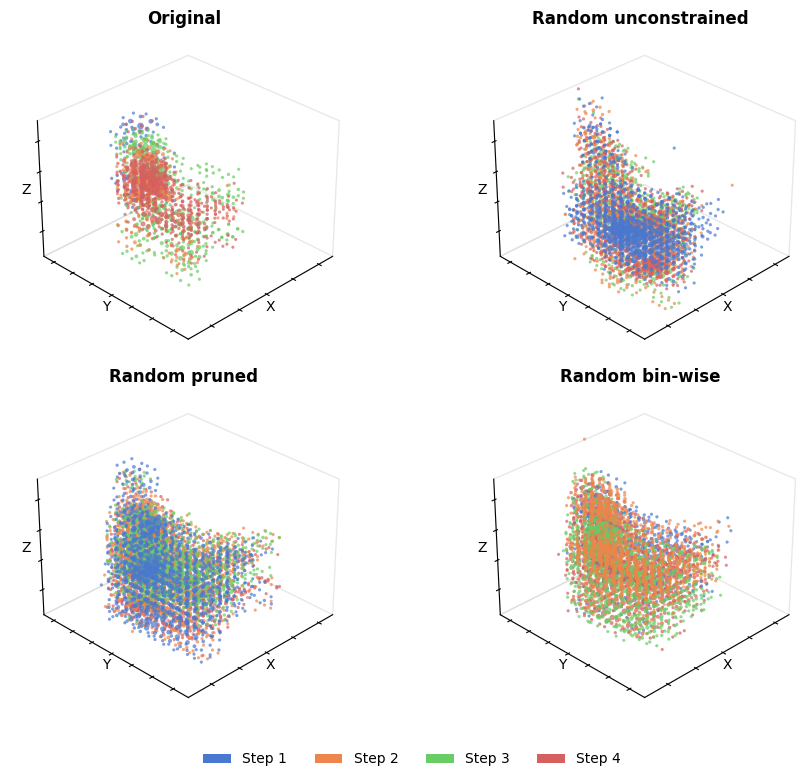

In [ ]:
# Example usage:
# configurations = {
#     'Original': original_propagation,
#     'Random unconstrained': random_unconstrained_propagation,
#     'Random pruned': pruned_random_propagation,
#     'Random bin-wise': binwise_random_propagation
# }
#
# # Try the different visualization approaches
fig1 = visualize_connectome_activation(configurations, neuron_position_data, sample_fraction=.2, jitter_ratio=0.02)
# plt.show()
plt.savefig('activation_voxels.png', dpi=600, bbox_inches='tight')
#
# fig2 = visualize_using_direct_neurons(configurations, neuron_position_data)
# plt.savefig('activation_neurons.png', dpi=600, bbox_inches='tight')
#
# # Try the hybrid approach which often gives the best results
# fig3 = visualize_hybrid(configurations, neuron_position_data)
# plt.savefig('activation_hybrid.png', dpi=600, bbox_inches='tight')), ncol=4, frameon=False)

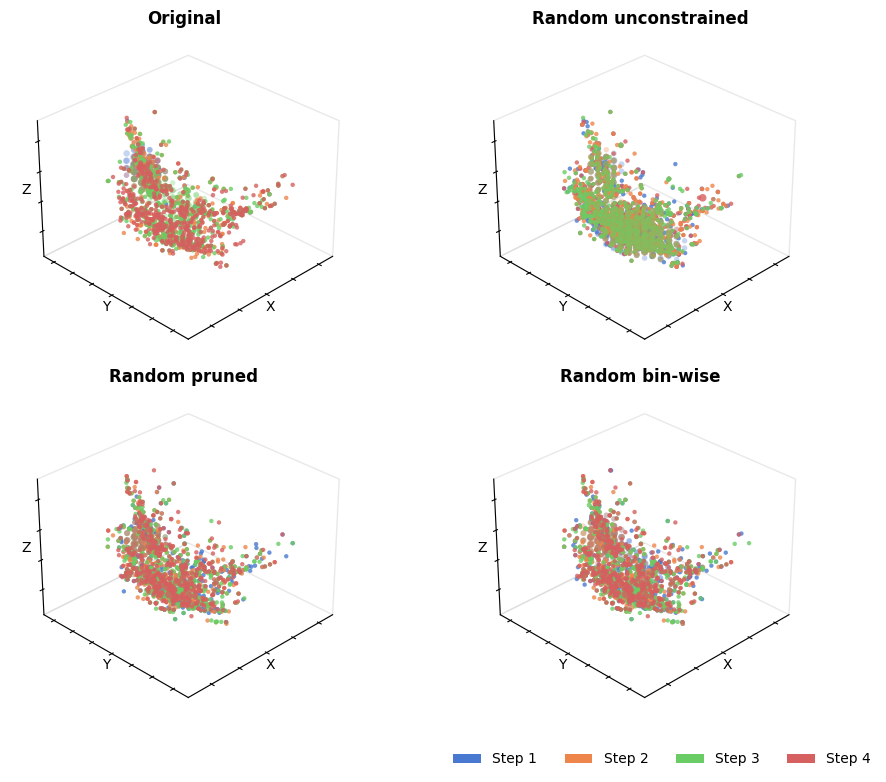

In [47]:
fig3 = visualize_hybrid(configurations, neuron_position_data)
plt.show()
# plt.savefig('activation_neurons.png', dpi=600, bbox_inches='tight')

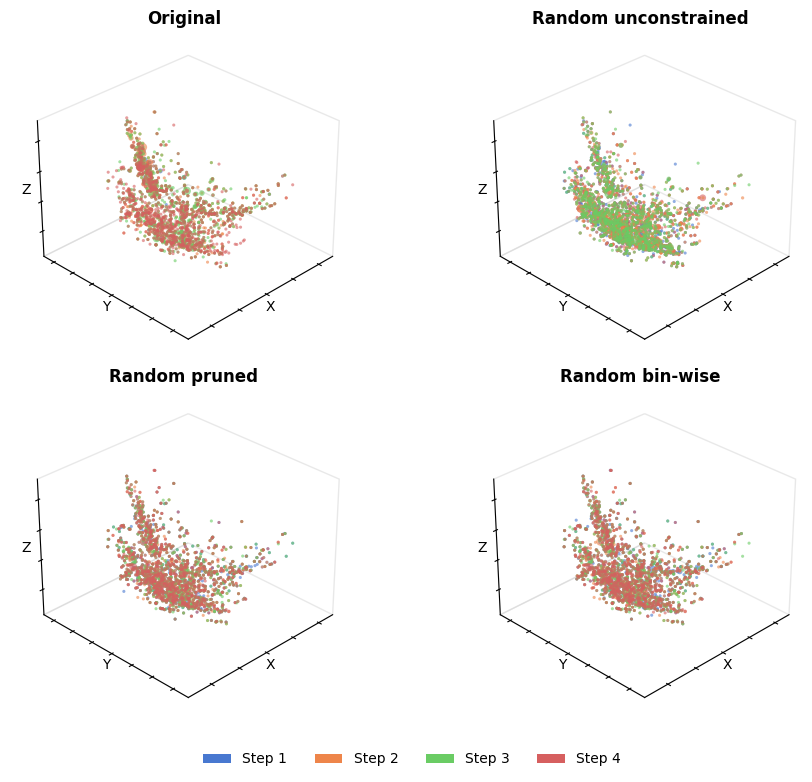

In [48]:
fig2 = visualize_using_direct_neurons(configurations, neuron_position_data)
plt.show()
# plt.savefig('activation_contours.png', dpi=600, bbox_inches='tight')

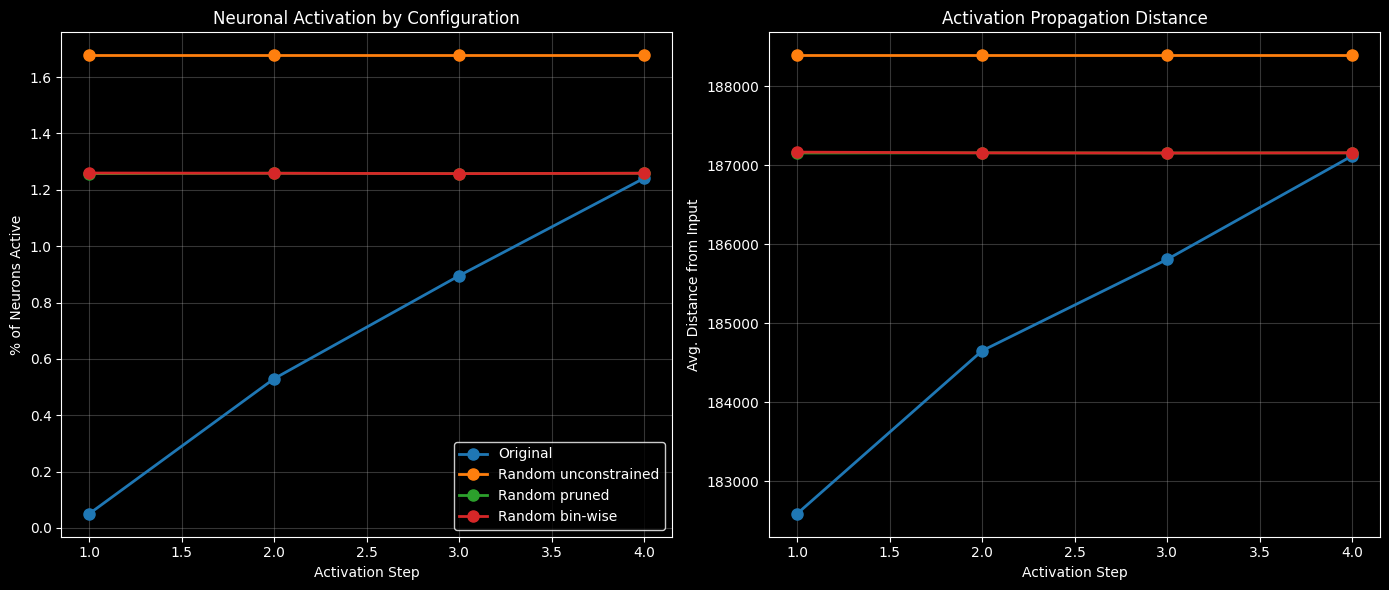

In [ ]:
fig = plot_activation_statistics(configurations, neuron_position_data)


plt.show()

In [103]:
from matplotlib.colors import to_rgba

def visualize_steps_separated_compact(
    propagations_dict,
    neuron_position_data,
    max_neurons_per_step=1000,
    voxel_size=20,
    smoothing=1.0,
    figsize=(16, 12),
    padding_percent=10,
):
    """
    Create a compact 4x4 grid of 3D visualizations with configurations as rows and steps as columns.

    Parameters:
    -----------
    propagations_dict : dict
        Dictionary with configuration names (keys) and propagation dataframes (values)
    neuron_position_data : pandas.DataFrame
        DataFrame with columns 'root_id', 'pos_x', 'pos_y', 'pos_z'
    max_neurons_per_step : int
        Maximum number of neurons to plot per step (for performance)
    voxel_size : int
        Size of voxels for density calculation
    smoothing : float
        Amount of Gaussian smoothing to apply
    figsize : tuple
        Figure size (width, height)
    padding_percent : float
        Percentage of padding to add around the active neurons

    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the 4x4 grid of visualizations
    """
    # Get bounds of active neurons
    bounds = get_active_neuron_bounds(
        propagations_dict, neuron_position_data, padding_percent
    )
    x_min, x_max = bounds["x_min"], bounds["x_max"]
    y_min, y_max = bounds["y_min"], bounds["y_max"]
    z_min, z_max = bounds["z_min"], bounds["z_max"]

    # Nature-friendly colors for each step
    step_colors = ["#4878D0", "#6ACC64", "#EE854A", "#D65F5F"]

    # Create a figure with 4x4 grid: rows=configurations, columns=steps
    # Replace figure and GridSpec creation with:
    fig, axes = plt.subplots(
        len(propagations_dict), 4, figsize=figsize, subplot_kw={"projection": "3d"}
    )

    # Process each configuration (rows)
    for i, (config_name, prop_df) in enumerate(propagations_dict.items()):
        # Merge with position data
        merged_data = pd.merge(prop_df, neuron_position_data, on="root_id")

        # Process each activation step (columns)
        for step in range(1, 5):
            # Get subplot position
            if len(propagations_dict) > 1:
                ax = axes[i, step-1]
            else:
                ax = axes[step-1]

            # Style the subplot
            ax.set_facecolor("white")
            ax.grid(False)
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
            ax.xaxis.pane.set_edgecolor("lightgray")
            ax.yaxis.pane.set_edgecolor("lightgray")
            ax.zaxis.pane.set_edgecolor("lightgray")

            # Remove tick labels
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_zticklabels([])

            # Add minimal axis labels only for the leftmost column and bottom row
            if step == 1:  # First column
                ax.set_ylabel("Y", labelpad=-10)
            if i == len(propagations_dict) - 1:  # Last row
                ax.set_xlabel("X", labelpad=-10)

            # Add Z label only for a subset
            if step == 1 and i == 0:
                ax.set_zlabel("Z", labelpad=-10)

            # Get color for this step
            color = step_colors[step - 1]

            # Filter data for this step
            act_col = f"activation_{step}"
            step_data = merged_data[merged_data[act_col] > 0].copy()

            # Add title to the top row only
            if i == 0:
                ax.set_title(f"Step {step}", fontsize=12, fontweight="bold", pad=5)

            # Add configuration label to the leftmost column only
            if step == 1:
                # Add y-axis label as configuration name
                ax.text2D(
                    -0.15,
                    0.5,
                    config_name,
                    transform=ax.transAxes,
                    va="center",
                    ha="center",
                    rotation=90,
                    fontsize=12,
                    fontweight="bold",
                )

            # Skip if no data
            if len(step_data) == 0:
                continue

            # Create 3D histogram for density visualization
            x_bins = np.linspace(x_min, x_max, voxel_size)
            y_bins = np.linspace(y_min, y_max, voxel_size)
            z_bins = np.linspace(z_min, z_max, voxel_size)

            H, edges = np.histogramdd(
                step_data[["pos_x", "pos_y", "pos_z"]].values,
                bins=[x_bins, y_bins, z_bins],
                weights=step_data[act_col].values,
            )

            # Apply Gaussian smoothing
            H_smooth = gaussian_filter(H, sigma=smoothing)

            # Skip if all zeros
            if H_smooth.max() == 0:
                continue

            # Get voxel coordinates
            x_centers = (x_bins[:-1] + x_bins[1:]) / 2
            y_centers = (y_bins[:-1] + y_bins[1:]) / 2
            z_centers = (z_bins[:-1] + z_bins[1:]) / 2

            # Create meshgrid of voxel centers
            X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")

            # Get non-zero voxels (above threshold of max value)
            threshold = 0.25 * H_smooth.max()
            mask = H_smooth > threshold

            # Skip if nothing to plot
            if not np.any(mask):
                continue

            # Get coordinates and values of voxels above threshold
            x_coords = X[mask]
            y_coords = Y[mask]
            z_coords = Z[mask]
            values = H_smooth[mask]

            # Normalize values for sizing
            norm_values = values / values.max()

            # Calculate sizes based on activation strength
            sizes = 40 * norm_values + 5

            # Calculate alpha values based on activation strength
            alphas = 0.3 + 0.4 * norm_values

            # Plot density as scatter with varying alpha
            rgba_colors = np.array([to_rgba(color, alpha=a) for a in alphas])

            ax.scatter(
                x_coords,
                y_coords,
                z_coords,
                c=rgba_colors,
                s=sizes,
                edgecolors="none",
                depthshade=True,
            )

            # Sample individual neurons for overlay
            if len(step_data) > max_neurons_per_step:
                neuron_sample = step_data.sample(
                    max_neurons_per_step, random_state=step + 42
                )
            else:
                neuron_sample = step_data

            # Scale activation values for better visualization
            max_activation = neuron_sample[act_col].max()
            if max_activation > 0:
                normalized_activation = neuron_sample[act_col] / max_activation
            else:
                normalized_activation = neuron_sample[act_col]

            # Calculate point sizes based on activation strength
            neuron_sizes = 15 * normalized_activation + 3

            # Plot individual neurons with higher opacity for emphasis
            ax.scatter(
                neuron_sample["pos_x"],
                neuron_sample["pos_y"],
                neuron_sample["pos_z"],
                c=[color],
                s=neuron_sizes,
                alpha=0.7,
                edgecolors="none",
                depthshade=True,
            )

            # Set consistent view angle
            ax.view_init(elev=30, azim=45)

            # Set axis limits
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_zlim(z_min, z_max)

    plt.subplots_adjust(wspace=-0.6, hspace=-0.05)

    return fig

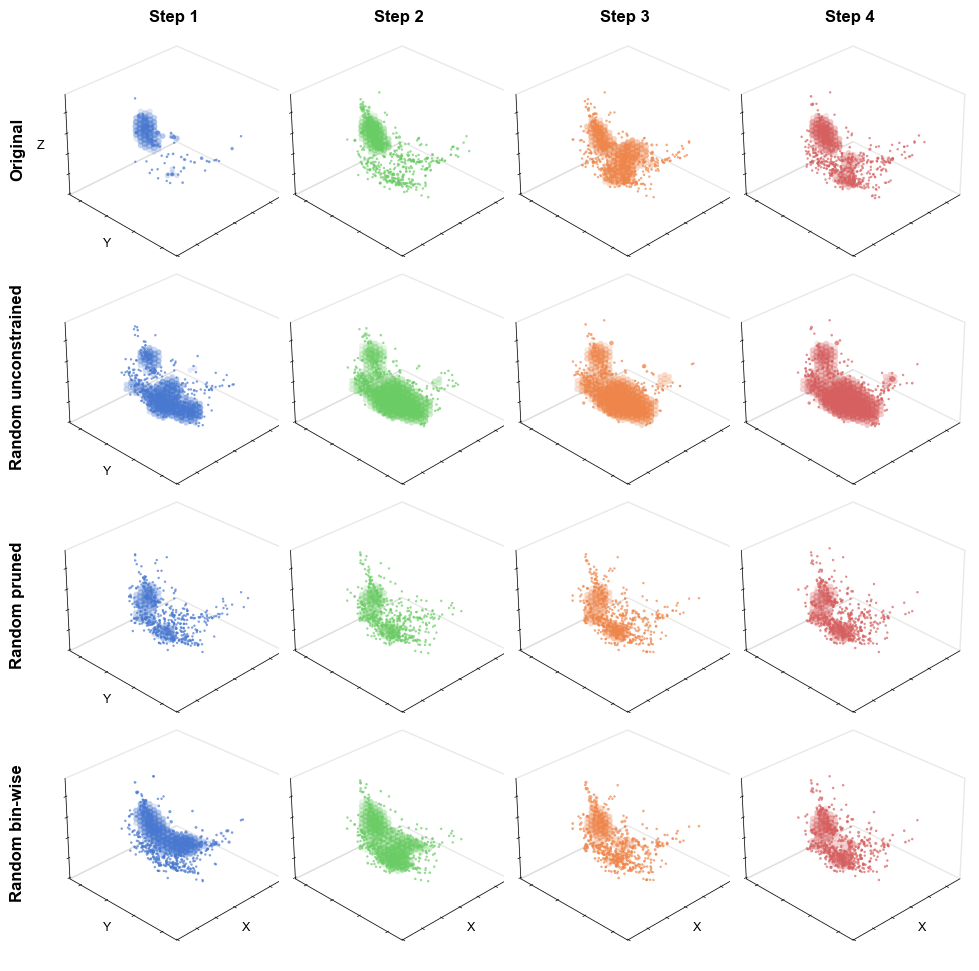

In [104]:
configurations = {
    'Original': propagation,
    'Random unconstrained': propagation2,
    'Random pruned': propagation3,
    'Random bin-wise': propagation4
}
# Visualize each activation step separately
fig1 = visualize_steps_separated_compact(
    configurations,
    neuron_position_data,
    max_neurons_per_step=500,
    voxel_size=25,
    smoothing=1.2,
    padding_percent=15,
)
plt.show()